# Image Patches

Notebook originally taken from Chris Tralie (https://github.com/ctralie/TDALabs/blob/master/Image%20Patches.ipynb)

This has been modified.

In this module, you will explore the topology of different collections of image patches.  Each image patch is a square $d \times d$ region of pixels.  Each pixel can be thought of as a dimension, so each patch lives in $\mathbb{R}^{d \times d}$, and a collection of patches can be thought of as a Euclidean point cloud in $\mathbb{R}^{d \times d}$

First, we perform all of the necessary library imports.  

In [4]:
# !pip install ripser

In [5]:
# !wget https://raw.githubusercontent.com/ctralie/TDALabs/master/GeomUtils.py

# !wget https://raw.githubusercontent.com/ctralie/DREiMac/3b36f442943014fe6a1595c7307e4c2082c2d075/dreimac/CSMSSMTools.py
# !wget https://raw.githubusercontent.com/ctralie/DREiMac/3b36f442943014fe6a1595c7307e4c2082c2d075/dreimac/Utils.py
# !wget https://raw.githubusercontent.com/ctralie/DREiMac/3b36f442943014fe6a1595c7307e4c2082c2d075/dreimac/ProjectiveCoordinates.py

If there is an error running some of the imports, uncomment some of the commands above.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from ripser import ripser
from persim import plot_diagrams
from GeomUtils import getGreedyPerm
import sys
from ProjectiveCoordinates import ProjectiveCoords, getStereoProjCodim1
import warnings
warnings.filterwarnings('ignore')

We now define a few functions which will help us to sample patches from an image and to plot a collection of patches

In [2]:
def getPatches(I, dim):
    """
    Given an image I, return all of the dim x dim patches in I
    :param I: An M x N image
    :param dim: The dimension of the square patches
    :returns P: An (M-dim+1)x(N-dim+1)x(dim^2) array of all patches
    """
    #http://stackoverflow.com/questions/13682604/slicing-a-numpy-image-array-into-blocks
    shape = np.array(I.shape*2)
    strides = np.array(I.strides*2)
    W = np.asarray(dim)
    shape[I.ndim:] = W
    shape[:I.ndim] -= W - 1
    if np.any(shape < 1):
        raise ValueError('Window size %i is too large for image'%dim)
    P = np.lib.stride_tricks.as_strided(I, shape=shape, strides=strides)
    P = np.reshape(P, [P.shape[0]*P.shape[1], dim*dim])
    return P

def imscatter(X, P, dim, zoom=1):
    """
    Plot patches in specified locations in R2
    
    Parameters
    ----------
    X : ndarray (N, 2)
        The positions of each patch in R2
    P : ndarray (N, dim*dim)
        An array of all of the patches
    dim : int
        The dimension of each patch
    
    """
    #https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points
    ax = plt.gca()
    for i in range(P.shape[0]):
        patch = np.reshape(P[i, :], (dim, dim))
        x, y = X[i, :]
        im = OffsetImage(patch, zoom=zoom, cmap = 'gray')
        ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
        ax.add_artist(ab)
    ax.update_datalim(X)
    ax.autoscale()
    ax.set_xticks([])
    ax.set_yticks([])

def plotPatches(P, zoom = 1):
    """
    Plot patches in a best fitting rectangular grid
    """
    N = P.shape[0] # N = number of patches
    d = int(np.sqrt(P.shape[1])) # side size of each square patch
    dgrid = int(np.ceil(np.sqrt(N))) # side size of plotting patches diagram
    ex = np.arange(dgrid)
    x, y = np.meshgrid(ex, ex) # grid of indicesof x and y coordinates
    X = np.zeros((N, 2))
    X[:, 0] = x.flatten()[0:N]
    X[:, 1] = y.flatten()[0:N]
    imscatter(X, P, d, zoom)

## Example 1: Patches On A Disc

First, we start off by sampling patches from an image representing a disc



In [3]:
%matplotlib inline

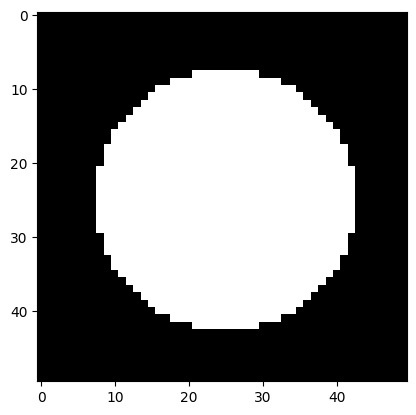

In [4]:
# First create an image of a disc
res = 50
R = res/2
[I, J] = np.meshgrid(np.arange(res) ,np.arange(res))
Im = ((I-R)**2 + (J-R)**2) < (0.5*R*R)
Im = 1.0*Im
plt.imshow(Im, interpolation='none', cmap='gray')
plt.show()

Notice that meshgrid creates two matrices with increasing numbers from 0 to 50 either left-to-right or top-to-bottom

In [5]:
print(I.shape)
print(I[:4][:,:7])
print(J.shape)
print(J[:4][:,:7])

(50, 50)
[[0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]]
(50, 50)
[[0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3]]


In [6]:
print(type(Im)) # numpy array
print(type(Im[0,0])) # entry type
print(Im.shape) # image of 50 x 50 pixels
print(Im.strides) # 8x50 bytes to move between row entries and 8 bytes to move along entries
print(Im.ndim) # 2-dimensional image

<class 'numpy.ndarray'>
<class 'numpy.float64'>
(50, 50)
(400, 8)
2


In [7]:
dim=5
shape = np.array(Im.shape*2)
print(shape)
W = np.asarray(dim)
shape[I.ndim:] = W
print(W)
print(shape)
shape[:I.ndim] -= W - 1
print(shape)
strides = np.array(I.strides*2)
print(strides)

[50 50 50 50]
5
[50 50  5  5]
[46 46  5  5]
[400   8 400   8]


We obtain `46x46=2116` patches of `5x5` pixels by means of using `numpy.lib.stride_tricks.as_strided` (see https://numpy.org/doc/stable/reference/generated/numpy.lib.stride_tricks.as_strided.html)

In [8]:
print(Im.shape)
P = np.lib.stride_tricks.as_strided(Im, shape=shape, strides=strides)
print(P.shape)
print(P[10][10])
P = np.reshape(P, [P.shape[0]*P.shape[1], dim*dim])
P.shape

(50, 50)
(46, 46, 5, 5)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 1. 1. 1.]]


(2116, 25)

Now, sample all unique 5x5 patches from this image, for a collection of patches which lives in 25 dimensional Euclidean space

In [9]:
dim = 5
P = getPatches(Im, dim)
P.shape

(2116, 25)

In [10]:
XSqr = np.sum(P**2, 1)
print(XSqr.shape)
print(XSqr)
D = XSqr[:, None] + XSqr[None, :] - 2*P.dot(P.T) # distances between patches

(2116,)
[0. 0. 0. ... 0. 0. 0.]


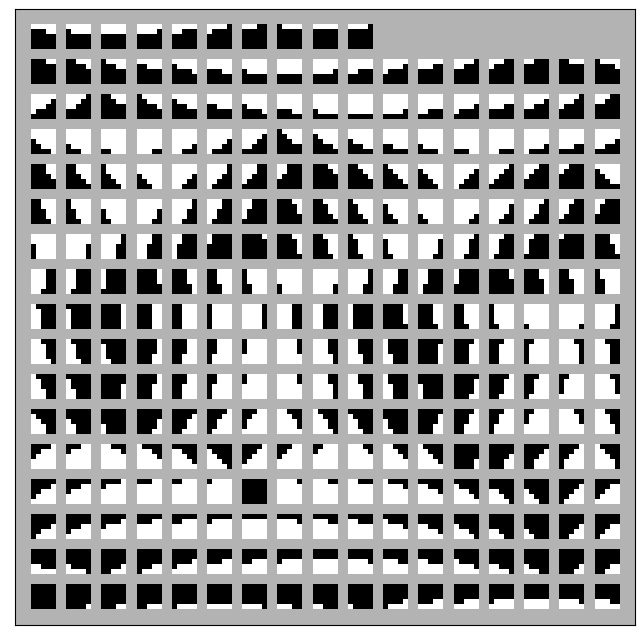

In [11]:
#Remove redundant patches to cut down on computation time
toKeep = [0]
for i in range(1, D.shape[0]):
    if np.sum(D[i, 0:i] == 0) > 0:
        continue
    toKeep.append(i)
    
P = P[np.array(toKeep), :]
plt.figure(figsize=(8, 8))
plotPatches(P, zoom=3.5)
ax = plt.gca() # matplotlib funciton for getting the current matplotlib.axes object
ax.set_facecolor((0.7, 0.7, 0.7)) # gray background
plt.show()

The image above only shows all different patches from the original image.

Now, let's compute persistence diagrams up to H2 for this collection of patches

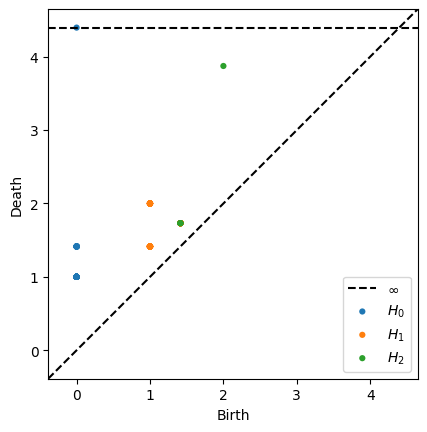

In [12]:
plt.figure()
dgms = ripser(P, maxdim=2)['dgms']
plot_diagrams(dgms)
plt.show()

* Based on the diagrams, what shape do the patches concentrate on?  Can you arrange the patches on that shape?

Let us arange patches in spherical shape (getting rid of patch with all 1's). First, compute again the distances between patches.

In [32]:
patch = P[5,:].reshape((5,5))
center_mass = np.array([0,0])
for y, row in enumerate(patch):
    for x, val in enumerate(row):
        if val==1:
            center_mass += [x-2, y-2]

center_mass = center_mass / 25

In [35]:
x, y = np.meshgrid(np.array(range(-2,3)), np.array(range(-2,3)))

In [50]:
np.sum(np.vstack((x[patch==1], y[patch==1])), axis=1) /25

array([0. , 0.4])

In [41]:
y[patch==1]

array([2, 2, 2, 2, 2])

In [54]:
center_mass**2 / sum(center_mass**2)

array([0., 1.])

In [77]:
XSqr[57]

25.0

In [78]:
P[57]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

In [121]:
def plotPatches_disk(P, zoom = 1):
    """
    Plot patches in a best fitting disk (adapted from plotPatches)
    """
    N = P.shape[0] # N = number of patches
    dim = int(np.sqrt(P.shape[1])) # side size of each square patch
    X = np.zeros((N, 2)) # prepare coordinate variable
    XSqr = np.sum(P**2, 1) # compute norms of patches
    x, y = np.meshgrid(np.array(range(-2,3)), np.array(np.array(range(2,-3,-1))))
    # compute the center mass of each patch
    for i in range(P.shape[0]):
        patch = np.reshape(P[i, :], (dim, dim))
        if np.all(patch): # discard patch with all 1's
            X[i, :] = [0,0]
            continue
        if not np.any(patch): # discard patch with all 0's
            X[i, :] = [0,0]
            continue
        center_mass = np.sum(
            np.vstack((x[patch==1], y[patch==1])), 
            axis=1) /25 # computes the coordinates of the center of mass of the patch
        
        position = center_mass / np.sqrt(sum(center_mass**2)) # normalize
        X[i, :] = (XSqr[i]+7*np.log(XSqr[i])+4)*position
        
    imscatter(X, P, dim, zoom)

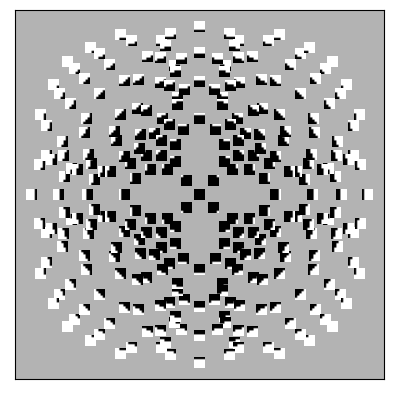

In [122]:
plotPatches_disk(P, zoom=1.5)
ax = plt.gca() # matplotlib funciton for getting the current matplotlib.axes object
ax.set_facecolor((0.7, 0.7, 0.7)) # gray background
ax.set_aspect('equal')
plt.show()

In [28]:
XSqr[57]

25.0

In [27]:
for i, patch in enumerate(P):
    if np.all(patch):
        print(i)

57


* What happens if you get rid of the constant all black or all white patches, and you normalize the rest of the patches to have unit norm?  What topological manifold is this?

Let us now normalize and do as suggested.

## Example 2: Oriented Line Segments

We now examine the collection of patches which hold oriented, blurry line segments that are varying distances from the center of the patch.  First, let's start by setting up the patches.  Below, the "dim" variable sets the patch resolution, and the "sigma" variable sets the blurriness (a larger sigma means blurrier line segments). 

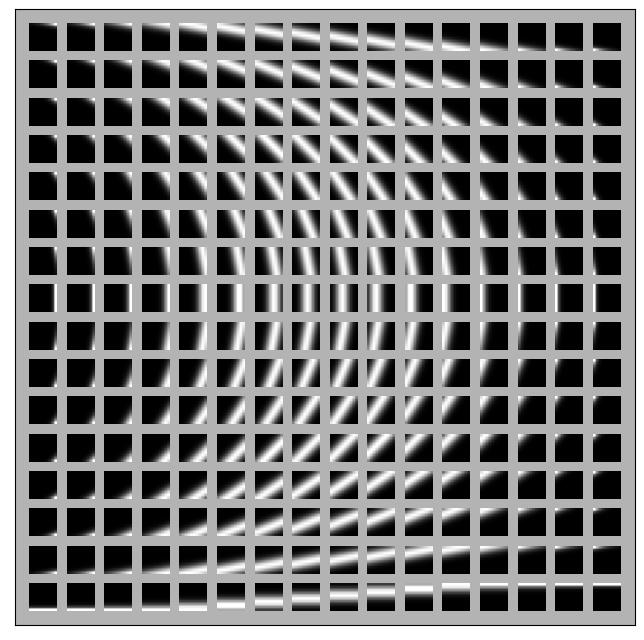

In [ ]:
def getLinePatches(dim, NAngles, NOffsets, sigma):
    N = NAngles*NOffsets
    P = np.zeros((N, dim*dim))
    thetas = np.linspace(0, np.pi, NAngles+1)[0:NAngles]
    #ps = np.linspace(-0.5*np.sqrt(2), 0.5*np.sqrt(2), NOffsets)
    ps = np.linspace(-1, 1, NOffsets)
    idx = 0
    [Y, X] = np.meshgrid(np.linspace(-0.5, 0.5, dim), np.linspace(-0.5, 0.5, dim))
    for i in range(NAngles):
        c = np.cos(thetas[i])
        s = np.sin(thetas[i])
        for j in range(NOffsets):
            patch = X*c + Y*s + ps[j]
            patch = np.exp(-patch**2/sigma**2)
            P[idx, :] = patch.flatten()
            idx += 1
    return P

P = getLinePatches(dim=10, NAngles = 16, NOffsets = 16, sigma=0.25)
plt.figure(figsize=(8, 8))
plotPatches(P, zoom=2)
ax = plt.gca()
ax.set_facecolor((0.7, 0.7, 0.7))
plt.show()

Now let's compute persistence diagrams for this collection of patches.  This time, we will compute with both $\mathbb{Z}/2$ coefficients and $\mathbb{Z}/3$ coefficients up to H2.

* Based on the persistence diagrams, what shape do the patches appear to concentrate on?  Can you arrange the patches on this shape to explain why?
* What happens to the persistence diagrams when you make sigma very small and the patches become sharper, or when you make sigma close to 1 and the patches become very blurry?  Can you explain what's happening geometrically?

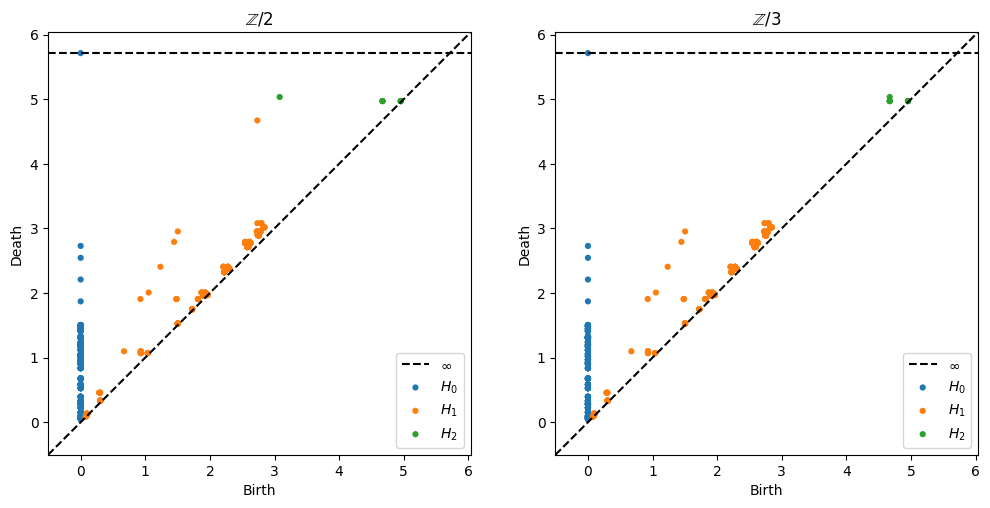

In [ ]:
dgmsz2 = ripser(P, coeff=2, maxdim=2)['dgms']
dgmsz3 = ripser(P, coeff=3, maxdim=2)['dgms']
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_diagrams(dgmsz2)
plt.title("$\mathbb{Z}/2$")
plt.subplot(122)
plot_diagrams(dgmsz3)
plt.title("$\mathbb{Z}/3$")
plt.show()

Now we will look at these patches using "projective coordinates" (finding a map to $RP^2$).


In [ ]:
np.shape(P)

(40000, 100)

In [ ]:
def plotProjBoundary():
    t = np.linspace(0, 2*np.pi, 200)
    plt.plot(np.cos(t), np.sin(t), 'c')
    plt.axis('equal')
    ax = plt.gca()
    ax.arrow(-0.1, 1, 0.001, 0, head_width = 0.15, head_length = 0.2, fc = 'c', ec = 'c', width = 0)
    ax.arrow(0.1, -1, -0.001, 0, head_width = 0.15, head_length = 0.2, fc = 'c', ec = 'c', width = 0)
    ax.set_facecolor((0.35, 0.35, 0.35))

P = getLinePatches(dim=10, NAngles = 200, NOffsets = 200, sigma=0.25)
# Construct projective coordinates object
pcoords = ProjectiveCoords(P, n_landmarks=200)
# Figure out index of maximum persistence dot in H1
I1 = pcoords.dgms_[1]
cocycle_idx = np.argsort(I1[:, 0] - I1[:, 1])[0:1]

# Perform projective coordinates using the representative cocycle from that point
res = pcoords.get_coordinates(proj_dim=2, perc=0.99, cocycle_idx=cocycle_idx)
X = res['X']
idx = getGreedyPerm(X, 400)['perm']
SFinal = getStereoProjCodim1(X[idx, :])
P = P[idx, :]

plt.figure(figsize=(8, 8))
imscatter(SFinal, P, 10)
plotProjBoundary()
plt.show()

## Example 3: Natural Image Patches

We will now generate a set of patches that occur in "natural images," which are essentially gradients from dark to light in different directions, which are centered at the patch.

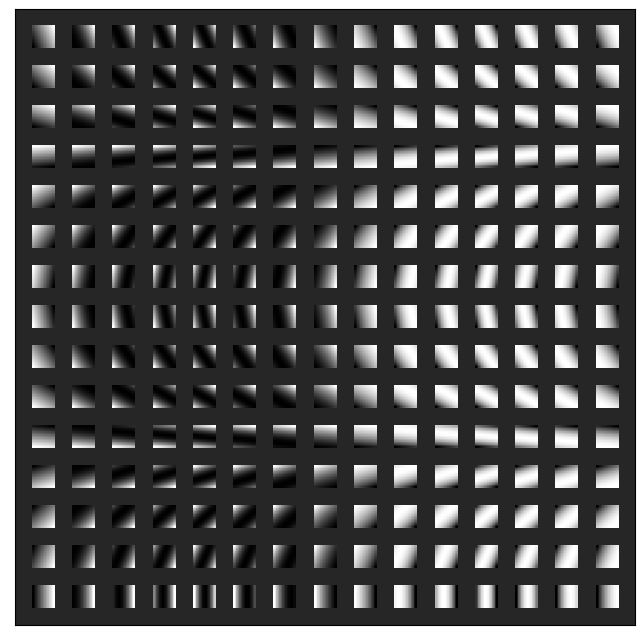

In [ ]:
def getNaturalImagePatches(ndir, nsharp, dim):
    N = ndir*nsharp
    t = np.linspace(0, 2*np.pi, ndir+1)[0:ndir]
    a, b = np.cos(t), np.sin(t)
    t = np.linspace(0, 2*np.pi, nsharp+1)[0:nsharp]
    c, d = np.cos(t), np.sin(t)
    a, b, c, d = a.flatten(), b.flatten(), c.flatten(), d.flatten()
    hdim = int((dim-1)/2)
    xr = np.linspace(-1, 1, dim)
    X, Y = np.meshgrid(xr, xr)
    P = np.zeros((N, dim*dim))
    idx = 0
    for i in range(a.size):
        for j in range(c.size):
            proj = a[i]*X + b[i]*Y
            p = c[j]*proj + d[j]*(proj**2)
            P[idx, :] = p.flatten()
            idx += 1
    return P

res = 15
dim = 8
P = getNaturalImagePatches(res, res, dim)

plt.figure(figsize=(8, 8))
plotPatches(P, zoom = 2)
ax = plt.gca()
ax.set_facecolor((0.15, 0.15, 0.15))
plt.show()

Now let's look at the persistent homology of this collection of patches with $\mathbb{Z} / 2\mathbb{Z}$ $\mathbb{Z} / 3\mathbb{Z}$ coefficients

#### Questions
* What topological manifold do these patches concentrate on, based on what you see in the persistence diagrams (hint: be careful that two points may be on top of each other in H1 for $\mathbb{Z} / 2\mathbb{Z}$)

Max 2 for Z2:
[[1.54663658 4.30074453]
 [1.54663658 4.30074453]]

Max 2 for Z3:
[[1.54663658 4.30074453]
 [1.53801286 2.17239165]]


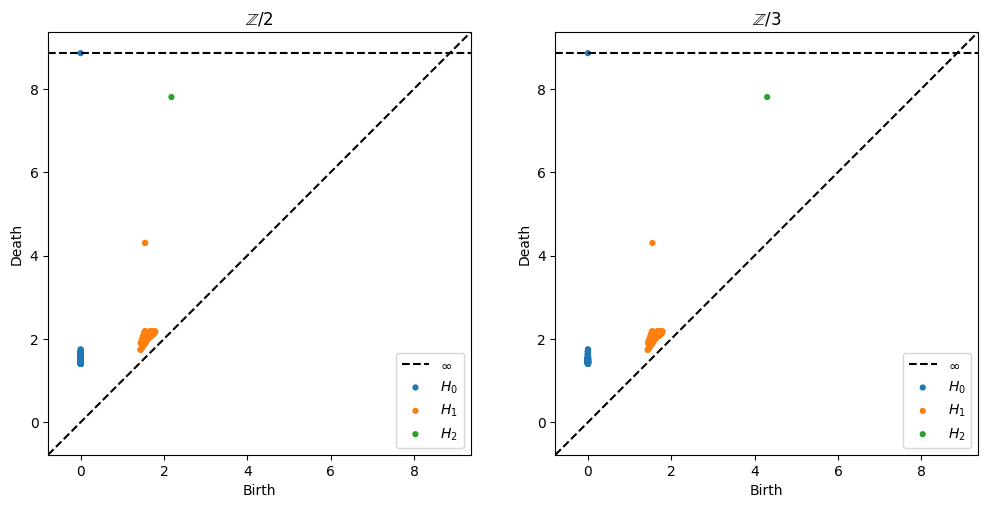

In [ ]:
res = 200
dgmsz2 = ripser(P, coeff=2, maxdim=2)['dgms']
dgmsz3 = ripser(P, coeff=3, maxdim=2)['dgms']

I1 = dgmsz2[1]
I2 = dgmsz3[1]
I1 = I1[np.argsort(I1[:, 0]-I1[:, 1]), :]
I2 = I2[np.argsort(I2[:, 0]-I2[:, 1]), :]
print("Max 2 for Z2:\n%s"%I1[0:2, :])
print("\nMax 2 for Z3:\n%s"%I2[0:2, :])

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_diagrams(dgmsz2)
plt.title("$\mathbb{Z}/2$")
plt.subplot(122)
plot_diagrams(dgmsz3)
plt.title("$\mathbb{Z}/3$")
plt.show()

Now let's look at these points with projective coordinates

In [ ]:
res = 500
dim = 8
P = getNaturalImagePatches(res, res, dim)

pcoords = ProjectiveCoords(P, n_landmarks=200)
# Figure out index of maximum persistence dot in H1
I1 = pcoords.dgms_[1]
cocycle_idx = np.argsort(I1[:, 0] - I1[:, 1])[0:1]
# Perform projective coordinates using the representative cocycle from that point
res = pcoords.get_coordinates(proj_dim=2, perc=0.99, cocycle_idx=cocycle_idx)
X = res['X']

idx = getGreedyPerm(X, 400)['perm']
SFinal = getStereoProjCodim1(X[idx, :])
P = P[idx, :]

plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_diagrams(pcoords.dgms_[1], labels=['H1'])
plt.subplot(122)
imscatter(SFinal, P, dim)
plotProjBoundary()
plt.show()

IndexError: ignored